In [2]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import math
import pyfolio as pf
import quantstats
plt.rcParams["figure.figsize"] = (12, 8) # (w, h)
import sys
from scipy.stats import rankdata
from scipy.stats import stats
from scipy.optimize import minimize

미국 주식, 미국 장기 국채, 금, 원자재 정도로 구성해 보겠습니다. TIPS나 다른 자산군을 넣는 것도 좋지만, 계산이 오래 걸릴 수 있어 일단 제외합니다. 

In [3]:
start = '2006-07-21'
end = '2021-05-19'

vti = web.DataReader("VTI", 'yahoo', start, end)['Adj Close'].to_frame("vti")
tlt = web.DataReader("TLT", 'yahoo', start, end)['Adj Close'].to_frame("tlt")
iau = web.DataReader("IAU", 'yahoo', start, end)['Adj Close'].to_frame("iau")
gsg = web.DataReader("GSG", 'yahoo', start, end)['Adj Close'].to_frame("gsg")

In [4]:
price_df = pd.concat([vti, tlt, iau, gsg], axis=1)
return_df = price_df.pct_change().dropna(axis=0)

In [6]:
return_df.head()

,vti,tlt,iau,gsg
Date,,,,
2006-07-24,0.019468,-0.000586,-0.012449,0.009137
2006-07-25,0.003370,-0.002932,0.009987,-0.009054
2006-07-26,0.002719,0.003646,0.005025,0.007513
2006-07-27,-0.002552,-0.001523,0.015484,0.010681
2006-07-28,0.008795,0.005751,0.003018,-0.011964


랜덤으로 VTI, TLT, IAU, GSG로 구성하는 5000개의 가상의 포트폴리오에 대해서 지표들을 구해봅니다.

In [7]:
np.random.seed(520)
num_ports = 5000
all_weights = np.zeros((num_ports, len(return_df.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(4))
    weights = weights/np.sum(weights)
    
    # Save weights
    all_weights[x,:] = weights
    
    # Expected return
    ret_arr[x] = np.sum((return_df.mean() * weights * 252))
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(return_df.cov()*252, weights)))
    
    # Sharpe Ratio (not exactly, it is return risk ratio, rrr)
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]

In [8]:
print('Max RRR: {}'.format(sharpe_arr.max()))
print('Location: {}'.format(sharpe_arr.argmax()))

Max RRR: 1.076587150383207
Location: 2130


2130번째 포트폴리오가 return risk ratio 1.077 정도로 가장 좋다고 나옵니다. 비중은 VTI 39.47%, TLT 42.51%, IAU 17.85%로 나오고, GSG는 사실상 가져가지 마라고 하고 있습니다. 2006년은 중국이 전세계 원자재를 흡수하는 원자재 슈퍼사이클 덕분에 원자재 가격이 매우 높았고, 그 후로 원자재 가격 자체는 줄곧 침체를 겪었습니다. 코로나 이후 올라오고 있으나 아직도 연 복리 수익률은 음수이니 수익률/변동성 비율 기준으로 찾는다면 안 가져가는 것이 맞습니다. 

In [9]:
# get allocation at argmax
print(all_weights[2130, :])

max_rrr_return = ret_arr[sharpe_arr.argmax()]
max_rrr_vol = vol_arr[sharpe_arr.argmax()]

[0.3947194  0.42507638 0.17848104 0.00172318]


최소 변동성도 궁금합니다. 어디인지 찾아보겠습니다. 최소 변동성에서는 원자재도 가져갑니다. Risk Parity 종류와 Maximum Diversification 등의 방법에서 원자재 성과가 아무리 나빠도 가져가라고 하는 이유가 여기 있습니다. 포트폴리오에 적절히 섞으면 변동성이 낮아집니다.

In [11]:
print('Min vol: {}'.format(vol_arr.min()))
print('Location: {}'.format(vol_arr.argmin()))

Min vol: 0.0844097566420165
Location: 467


In [12]:
print(all_weights[467, :])

min_vol_return = ret_arr[vol_arr.argmin()]
min_vol_vol = vol_arr[vol_arr.argmin()]

[0.29052547 0.50168949 0.12233647 0.08544857]


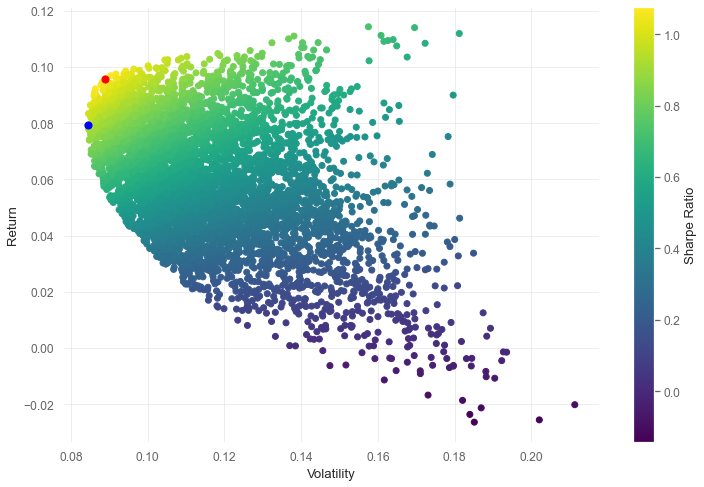

In [14]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_rrr_vol, max_rrr_return, c='red', s=50) # red dot
plt.scatter(min_vol_vol, min_vol_return, c='blue', s=50) # blue dot
plt.show()

In [15]:
def get_ret_vol_rrr(weights):
    weights = np.array(weights)
    ret = np.sum(return_df.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(return_df.cov()*252, weights)))
    rrr = ret/vol
    return np.array([ret, vol, rrr])

def neg_sharpe(weights):
    # the number 2 is the sharpe ratio index from the get_ret_vol_rrr
    return get_ret_vol_rrr(weights)[2] * -1

def check_sum(weights):
    #return 0 if sum of the weights is 1
    return np.sum(weights)-1

최적화 시작 지점과 경계를 지정합니다.

In [16]:
cons = ({'type':'eq', 'fun':check_sum})
bounds = ((0,1),(0,1),(0,1),(0,1))
initial = [0.25, 0.25, 0.25, 0.25]

In [18]:
optimizer = minimize(neg_sharpe, initial, method='SLSQP', bounds = bounds, constraints = cons)
print(optimizer)

     fun: -1.0867224730980578
     jac: array([-2.56896019e-05, -1.32620335e-05,  1.14575028e-04,  1.32208484e+00])
 message: 'Optimization terminated successfully.'
    nfev: 32
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([3.82353210e-01, 4.76524957e-01, 1.41121832e-01, 7.39603901e-17])


최적화된 수익률, 변동성, return risk ratio 입니다. 랜덤으로 5000개 만든 것도 그리 뒤쳐지지는 않으나, 최적의 결과를 찾아보았습니다. 

In [19]:
get_ret_vol_rrr(optimizer.x)

array([0.09484005, 0.08727164, 1.08672247])

위 그림에서 최대 수익률이 12% 위로는 가지 않습니다. 이제 Efficient Frontier를 그려 보겠습니다. 가능한 수익들 중 최소 변동성을 가지게 하면 됩니다.

In [20]:
frontier_y = np.linspace(0, 0.12, 200)

In [21]:
def min_vol(weights):
    return get_ret_vol_rrr(weights)[1]

In [24]:
frontier_x = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_rrr(w)[0] - possible_return})
    
    result = minimize(min_vol,initial, method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

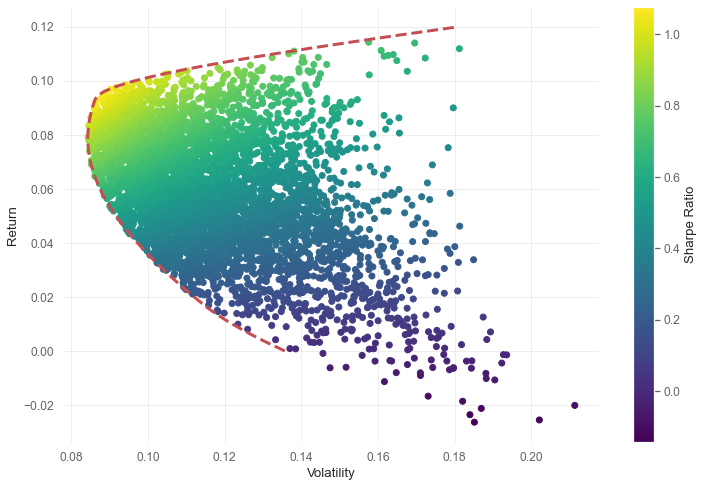

In [25]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x,frontier_y, 'r--', linewidth=3)
#plt.savefig('cover.png')
plt.show()